In [20]:
import pandas as pd
import json
import urllib.request, urllib.error, urllib.parse
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from docx import Document
from docx.shared import Inches
from docx.enum.text import WD_ALIGN_PARAGRAPH
from bs4 import BeautifulSoup 
import urllib.request 
import nltk 
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
import warnings
warnings.filterwarnings("ignore")



stopwords = nltk.corpus.stopwords.words('english')
newStopWords = ['the','4',".","me.","many","the..."]
stopwords.extend(newStopWords)



data = pd.read_csv("Campus Academic Management Survey.csv")

part1 = data.iloc[:,1:13]
part2 = data.iloc[:,13:20]
part3 = data.iloc[:,20:30]

In [21]:
def eText(question):
    text = ""
    for q in question.dropna():
        text = text + str(q) + "  "
    while '  ' in text:
        text = text.replace('  ', '. ')
    while '..' in text:
        text = text.replace('..', '.')
        
    
    return(text)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 
    ).generate(str(data))

    fig = plt.figure(1, figsize=(20, 20))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)
    plt.imshow(wordcloud)
    plt.show()
    fig.savefig('WorldCloud.png', bbox_inches='tight')
    document.add_picture('WorldCloud.png', width=Inches(6))

In [22]:

def QSentiment(text):

    APPLICATION_ID = "13ea824b"
    APPLICATION_KEY = "7a81e3feb66047de3fd85e16f7b46434"

    def call_api(endpoint, parameters):
      url = 'https://api.aylien.com/api/v1/' + endpoint
      headers = {
          "Accept":                             "application/json",
          "Content-type":                       "application/x-www-form-urlencoded",
          "X-AYLIEN-TextAPI-Application-ID":    APPLICATION_ID,
          "X-AYLIEN-TextAPI-Application-Key":   APPLICATION_KEY
      }
      opener = urllib.request.build_opener()
      request = urllib.request.Request(url,
        urllib.parse.urlencode(parameters).encode('utf-8'), headers)
      response = opener.open(request);
      return json.loads(response.read().decode())

    parameters = {"text": eText(text)}
    sentiment = call_api("sentiment", parameters)
    return (sentiment["polarity"])

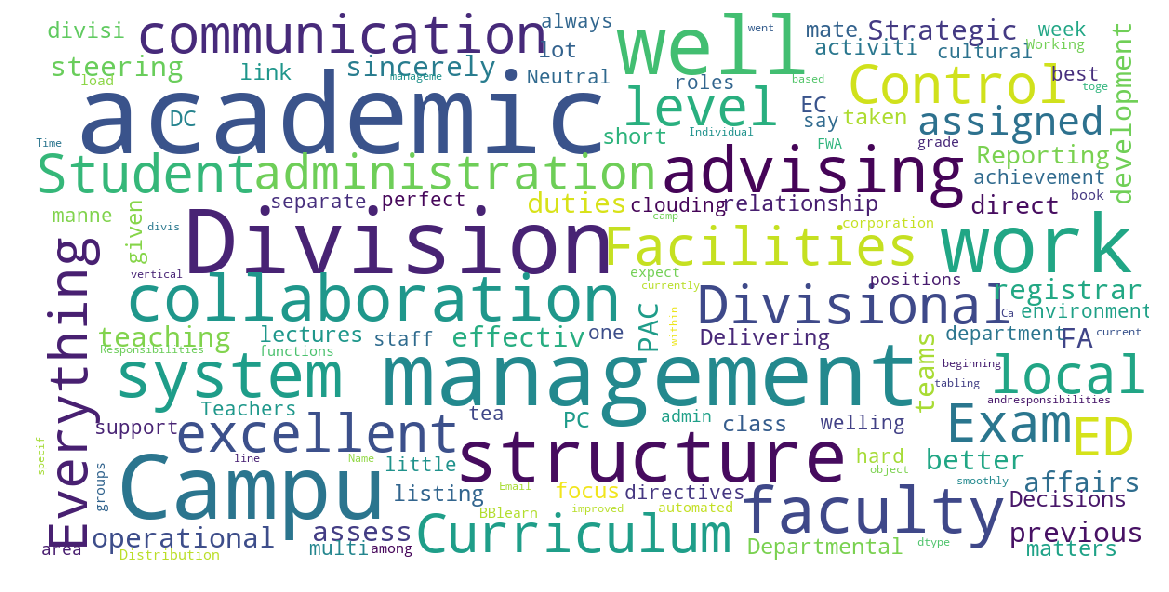

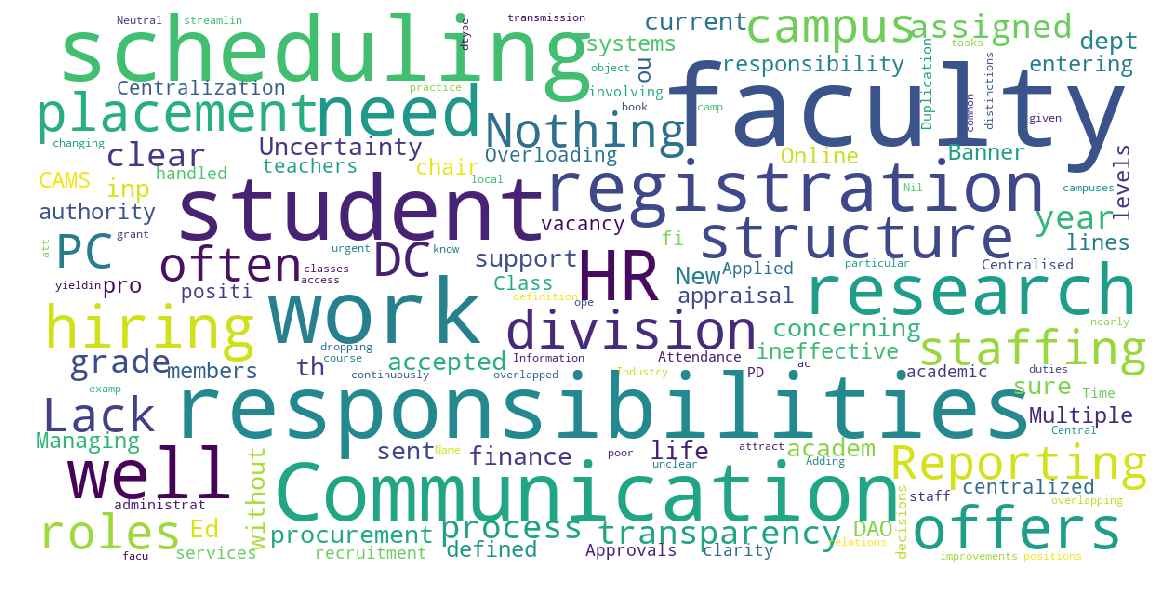

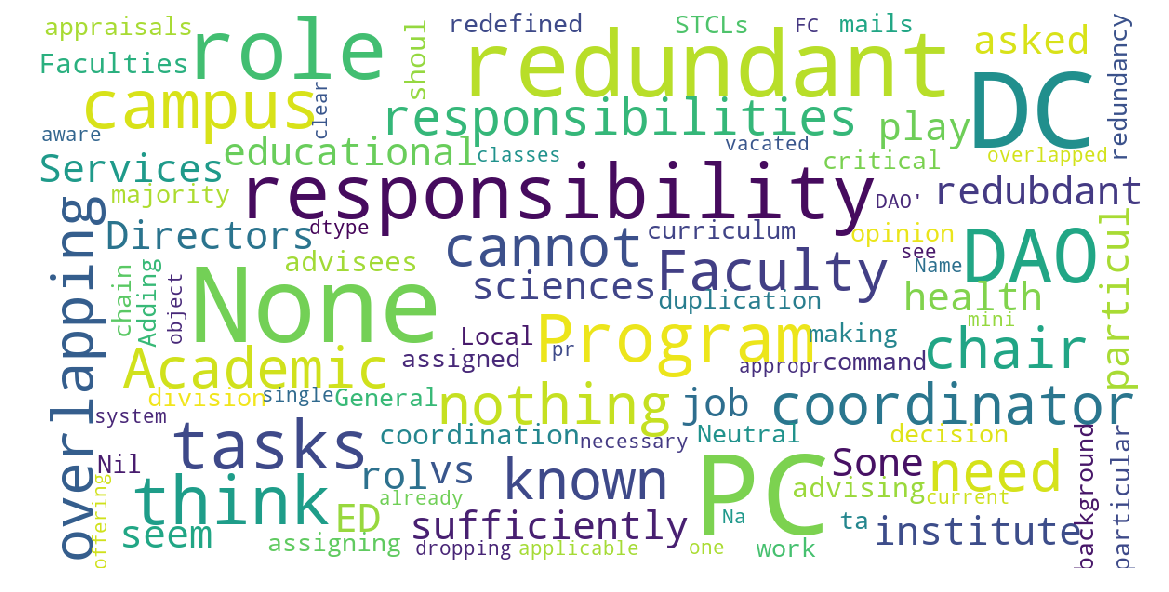

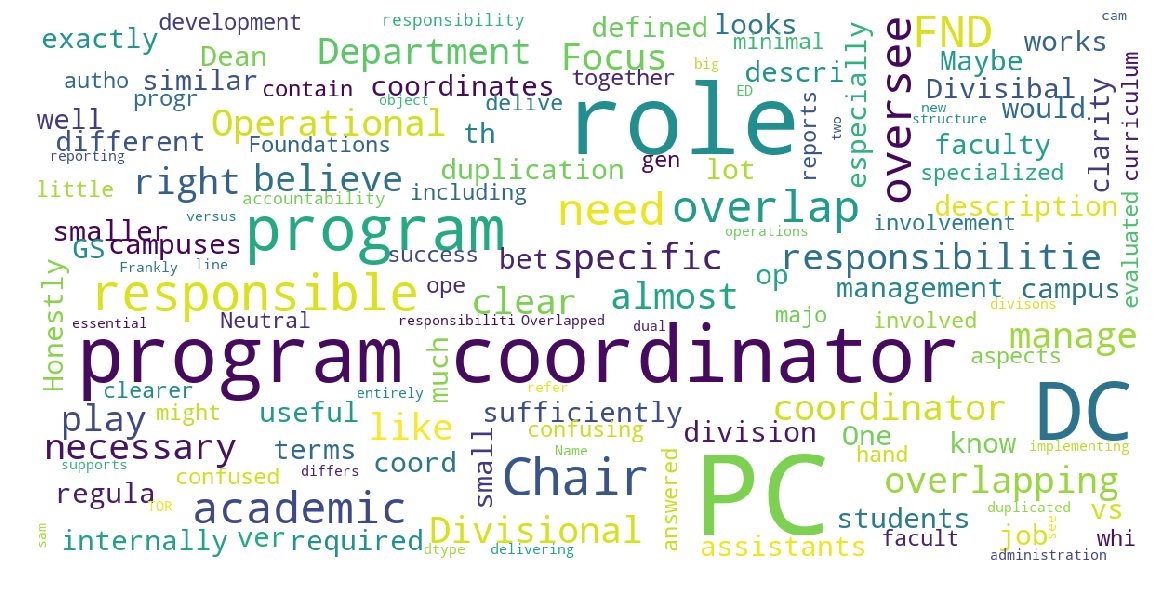

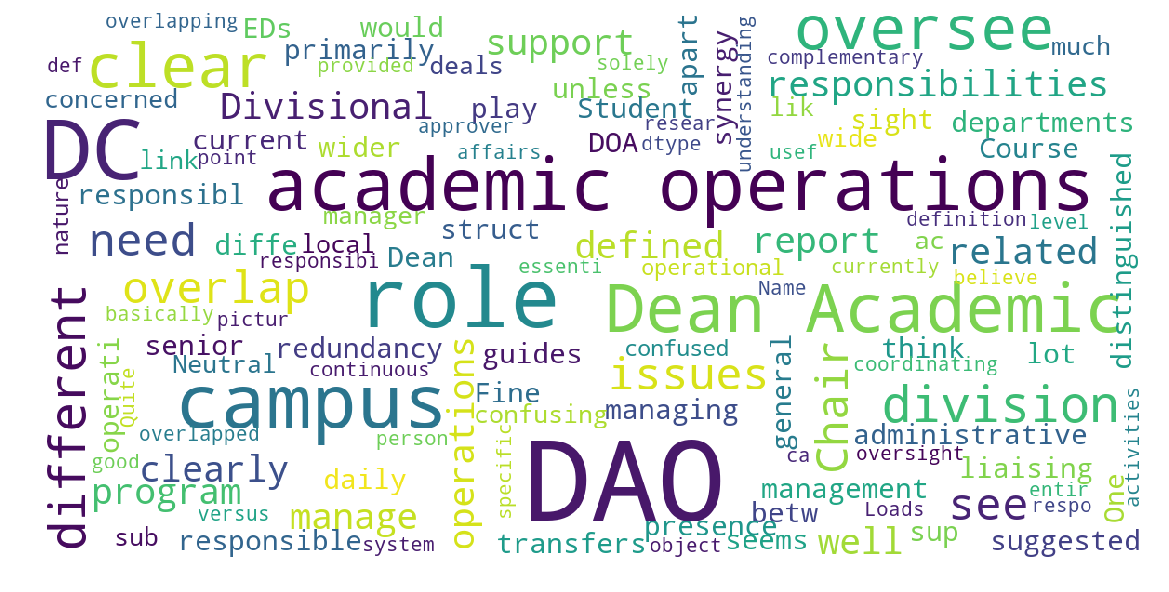

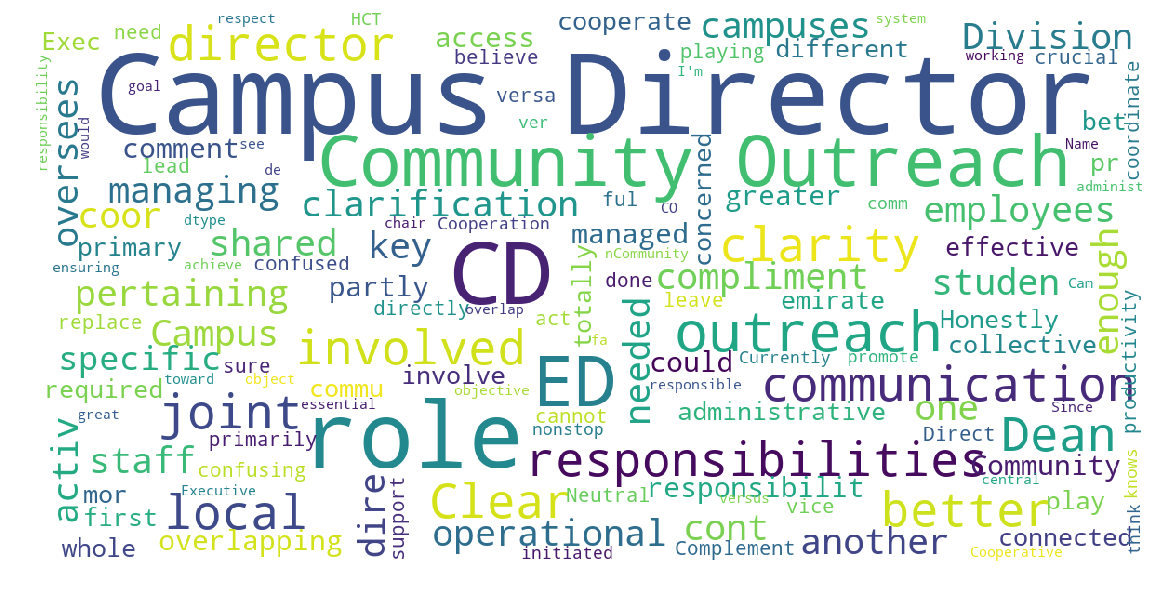

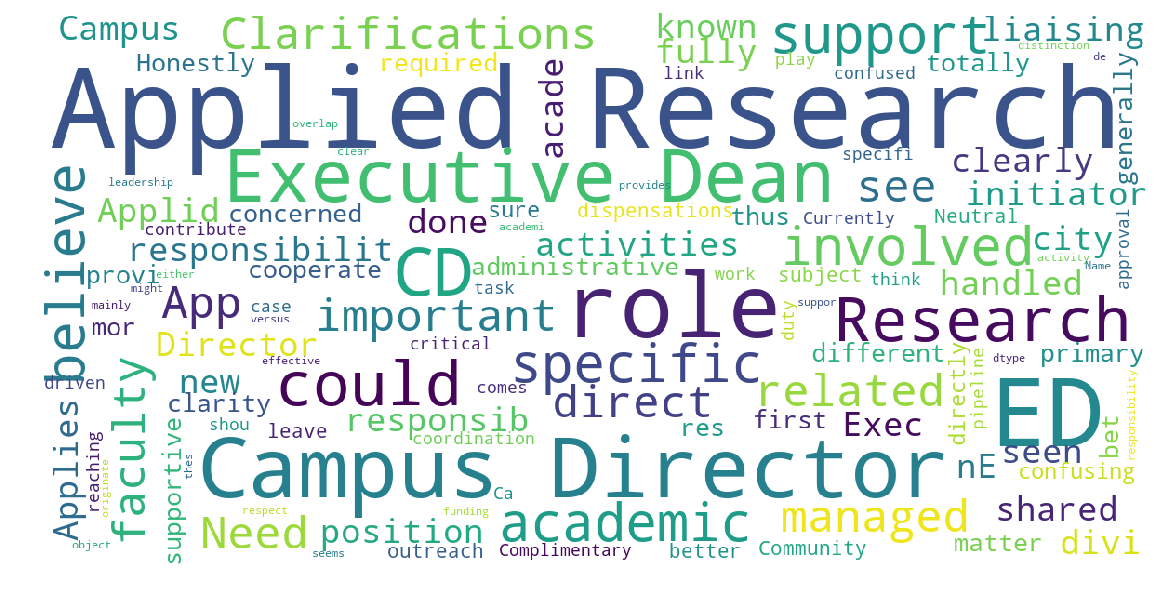

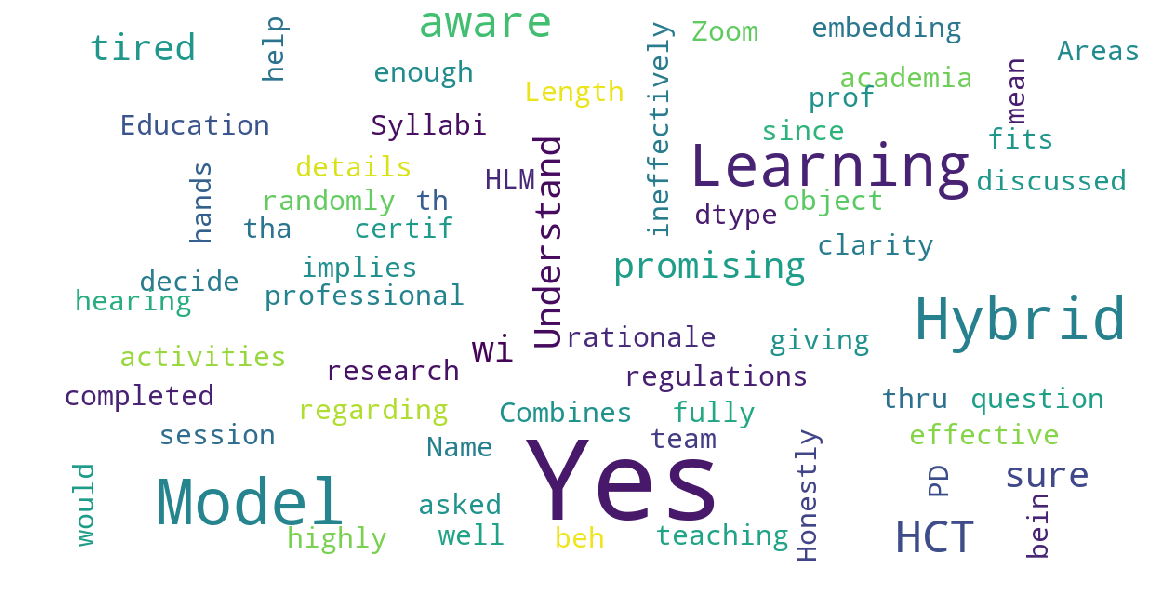

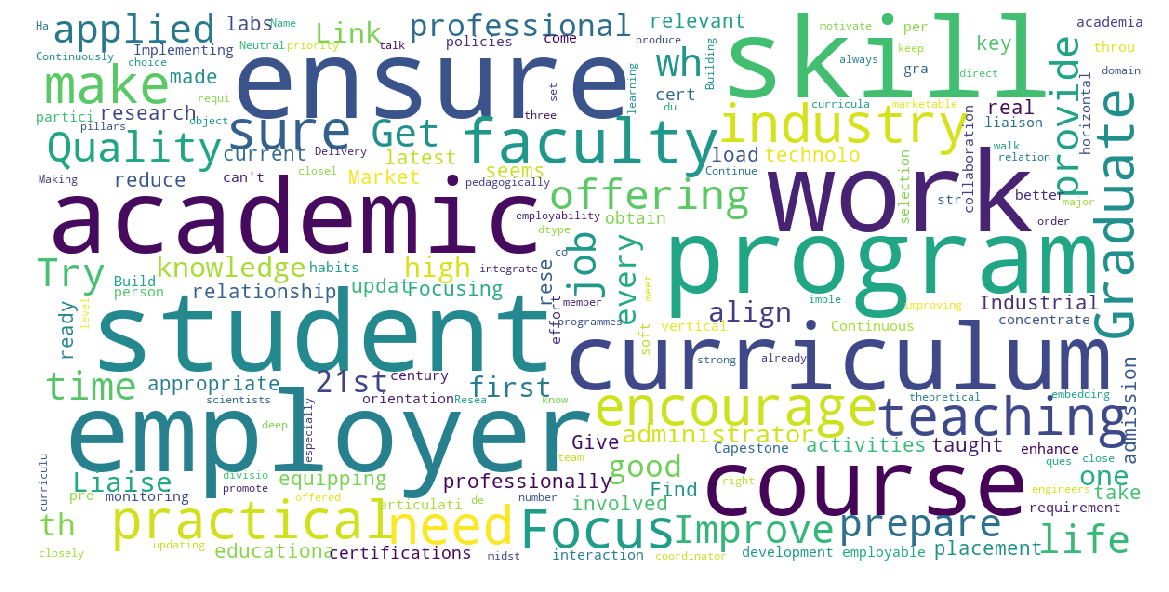

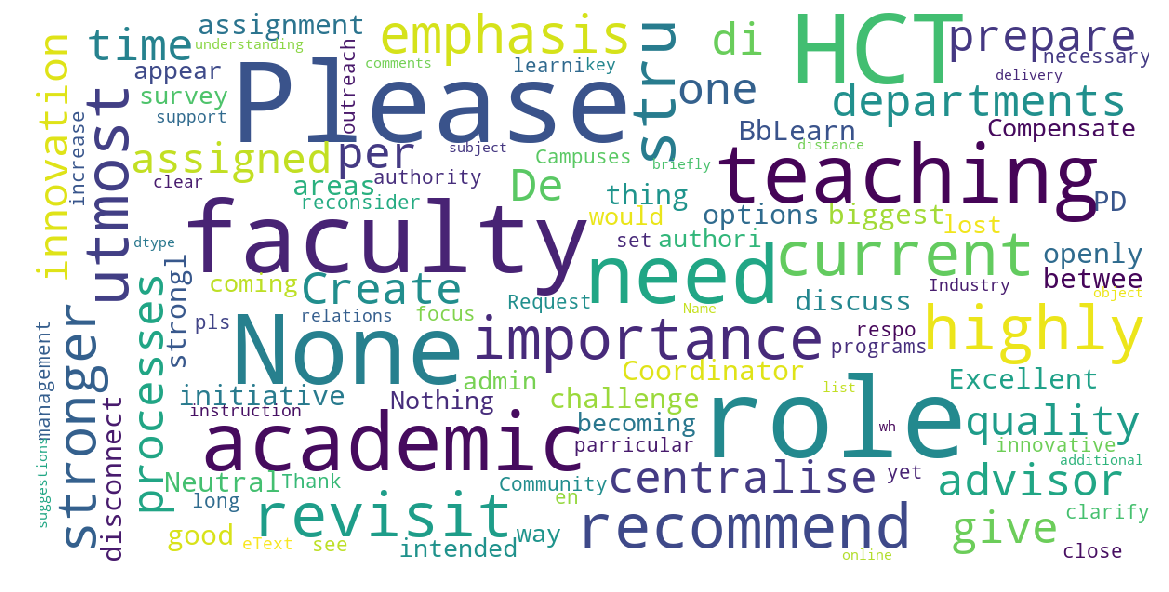

In [23]:
document = Document()
writer = pd.ExcelWriter('OpenEnded.xlsx')

questions = part3.columns

st = pd.DataFrame(questions, columns=["Question"])

st["Average"] = 0
st["Median"] = 0
st["Std"] = 0
st["Sentiment"] = ""


i = 0
for q in questions:

    text = eText(part3[q])
    words = word_tokenize(text)

    freqTable = dict()

    for word in words:
        word = word.lower()
        if word in stopwords:
            continue
        if word in freqTable:
            freqTable[word] += 1
        else:
            freqTable[word] = 1

    sentences = sent_tokenize(text)
    sentenceValue = dict()

    for sentence in sentences:
         for index, wordValue in enumerate(freqTable, start=1):
                if wordValue in sentence.lower(): 
                    if sentence in sentenceValue:  
                        sentenceValue[sentence] += freqTable[wordValue] # index return value of occurence of that word
                    else:
                        sentenceValue[sentence] = freqTable[wordValue]
    

    dictlist = []

    for key, value in sentenceValue.items():
        temp = [key,value]
        dictlist.append(temp)

    summary = pd.DataFrame(dictlist, columns=["Statement","Weight"])
    summary.sort_values(["Weight"], ascending=False, inplace=True)
    i = i + 1
    summary.to_excel(writer,"sheet"+str(i))
    st["Average"][st["Question"]==q] = round(summary["Weight"].mean(),2)
    st["Median"][st["Question"]==q] = round(summary["Weight"].median(),2)
    st["Std"][st["Question"]==q] = round(summary["Weight"].std(),2)
    st["Sentiment"][st["Question"]==q] = QSentiment(part3[q].dropna())
    document.add_paragraph(q)
    show_wordcloud(part3[q].dropna())
    
st.to_excel(writer,"St")    
    
writer.save()

document.save("demo.docx")